In [1]:
import os
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
from ast import literal_eval
import warnings
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
import lightgbm as lgb

warnings.filterwarnings('ignore')

data_path = './dataset/'

def read_df(path, file_name, nrows=None):
    df = pd.read_csv(path + file_name, dtype={'fullVisitorId': 'str', 'visitId': 'str'}, chunksize=nrows)
    return df

train_df = read_df(data_path, 'train.csv')
test_df = read_df(data_path, 'test.csv')

print(train_df.shape)

# Drop
train_df = train_df.drop(['visitId', 'visitStartTime', 'campaignCode'], axis=1)
test_df = test_df.drop(['visitId', 'visitStartTime'], axis=1)

print()
# Fill NA
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

# Encode non-numerics
def func(df):
    cols = df.columns.values
    for col in cols:
        digit_vals={}
        def convert_to_int(val):
            return digit_vals[val]
        if df[col].dtype != np.int64 and df[col].dtype != np.float64 and col not in ['date', 'fullVisitorId']:
            cont = df[col].values.tolist()
            uniques = set(cont)
            x = 0
            for unique in uniques:
                if unique not in digit_vals:
                    digit_vals[unique] = x
                    x+=1
            df[col] = list(map(convert_to_int, df[col]))
    return df

train_df = func(train_df)
test_df = func(test_df)

(1655816, 38)



In [4]:
print(train_df.columns.values)

['channelGrouping' 'date' 'fullVisitorId' 'visitNumber' 'browser'
 'operatingSystem' 'isMobile' 'mobileDeviceModel' 'deviceCategory'
 'continent' 'subContinent' 'country' 'region' 'metro' 'city'
 'networkDomain' 'hits_y' 'pageviews' 'bounces' 'newVisits'
 'sessionQualityDim' 'timeOnSite' 'transactions' 'transactionRevenue'
 'totalTransactionRevenue' 'campaign' 'source' 'medium' 'keyword'
 'referralPath' 'isTrueDirect' 'index' 'value' 'month' 'week']


In [29]:
# Split DF
train_x = train_df.drop(['fullVisitorId', 'transactionRevenue', 'totalTransactionRevenue','date','transactions'], axis = 1)
train_y = train_df["totalTransactionRevenue"].values
trn_x, val_x, trn_y, val_y = train_test_split(train_x, train_y, test_size = 0.2, shuffle = False)
test_x = test_df.drop(['fullVisitorId', 'transactionRevenue', 'totalTransactionRevenue','date','transactions'], axis = 1)
test_y = np.log1p(test_df["totalTransactionRevenue"].values)

trn_y = np.log1p(trn_y)
val_y = np.log1p(val_y)

# Transform to lgb dataset
train_data = lgb.Dataset(trn_x, label = trn_y)
test_data = lgb.Dataset(val_x, label = val_y, reference=train_data)

# Model parameters
parameters = {
    'objective': 'regression',
    'metric': 'rmse',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 35,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.1,
}

# Train
model = lgb.train(parameters, train_data, valid_sets=test_data, num_boost_round=300, early_stopping_rounds=100)

[1]	valid_0's rmse: 1.80808
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 1.76792
[3]	valid_0's rmse: 1.73708
[4]	valid_0's rmse: 1.70428
[5]	valid_0's rmse: 1.67833
[6]	valid_0's rmse: 1.67572
[7]	valid_0's rmse: 1.65373
[8]	valid_0's rmse: 1.64336
[9]	valid_0's rmse: 1.6411
[10]	valid_0's rmse: 1.6397
[11]	valid_0's rmse: 1.62899
[12]	valid_0's rmse: 1.62764
[13]	valid_0's rmse: 1.61917
[14]	valid_0's rmse: 1.60459
[15]	valid_0's rmse: 1.60406
[16]	valid_0's rmse: 1.5933
[17]	valid_0's rmse: 1.58935
[18]	valid_0's rmse: 1.589
[19]	valid_0's rmse: 1.57927
[20]	valid_0's rmse: 1.57241
[21]	valid_0's rmse: 1.56811
[22]	valid_0's rmse: 1.56207
[23]	valid_0's rmse: 1.55777
[24]	valid_0's rmse: 1.55748
[25]	valid_0's rmse: 1.55722
[26]	valid_0's rmse: 1.55384
[27]	valid_0's rmse: 1.55199
[28]	valid_0's rmse: 1.55085
[29]	valid_0's rmse: 1.54859
[30]	valid_0's rmse: 1.54618
[31]	valid_0's rmse: 1.54608
[32]	valid_0's rmse: 1.54476
[33]	valid_0's rmse: 1.5

[277]	valid_0's rmse: 1.50705
[278]	valid_0's rmse: 1.50711
[279]	valid_0's rmse: 1.50695
[280]	valid_0's rmse: 1.507
[281]	valid_0's rmse: 1.50699
[282]	valid_0's rmse: 1.50688
[283]	valid_0's rmse: 1.50686
[284]	valid_0's rmse: 1.50687
[285]	valid_0's rmse: 1.50684
[286]	valid_0's rmse: 1.50681
[287]	valid_0's rmse: 1.50689
[288]	valid_0's rmse: 1.50687
[289]	valid_0's rmse: 1.50691
[290]	valid_0's rmse: 1.507
[291]	valid_0's rmse: 1.50699
[292]	valid_0's rmse: 1.50709
[293]	valid_0's rmse: 1.50704
[294]	valid_0's rmse: 1.50715
[295]	valid_0's rmse: 1.50693
[296]	valid_0's rmse: 1.50696
[297]	valid_0's rmse: 1.50699
[298]	valid_0's rmse: 1.50705
[299]	valid_0's rmse: 1.50694
[300]	valid_0's rmse: 1.50694
Did not meet early stopping. Best iteration is:
[286]	valid_0's rmse: 1.50681


In [30]:
from sklearn.metrics import mean_squared_error
preds = model.predict(test_x, num_iteration=model.best_iteration)
print('The rmse of prediction is:', mean_squared_error(test_y, preds) ** 0.5)

The rmse of prediction is: 1.826680706844177


In [7]:
submission = test_df[['fullVisitorId']]
submission['PredictedLogRevenue'] = np.expm1(preds)
submission = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum()
submission["PredictedLogRevenue"] = np.log1p(submission["PredictedLogRevenue"])
print(submission.head())

                     PredictedLogRevenue
fullVisitorId                           
0000196310838896290             0.009220
0000268499301061358             7.154482
0000900085223565423             7.171304
000101445922736554              7.261824
0001180870711546826             7.224999


[1]	valid_0's rmse: 1.80808
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 1.76792
[3]	valid_0's rmse: 1.73708
[4]	valid_0's rmse: 1.70428
[5]	valid_0's rmse: 1.67833
[6]	valid_0's rmse: 1.67572
[7]	valid_0's rmse: 1.65373
[8]	valid_0's rmse: 1.64336
[9]	valid_0's rmse: 1.6411
[10]	valid_0's rmse: 1.6397
[11]	valid_0's rmse: 1.62899
[12]	valid_0's rmse: 1.62764
[13]	valid_0's rmse: 1.61917
[14]	valid_0's rmse: 1.60459
[15]	valid_0's rmse: 1.60406
[16]	valid_0's rmse: 1.5933
[17]	valid_0's rmse: 1.58935
[18]	valid_0's rmse: 1.589
[19]	valid_0's rmse: 1.57927
[20]	valid_0's rmse: 1.57241
[21]	valid_0's rmse: 1.56811
[22]	valid_0's rmse: 1.56207
[23]	valid_0's rmse: 1.55777
[24]	valid_0's rmse: 1.55748
[25]	valid_0's rmse: 1.55722
[26]	valid_0's rmse: 1.55384
[27]	valid_0's rmse: 1.55199
[28]	valid_0's rmse: 1.55085
[29]	valid_0's rmse: 1.54859
[30]	valid_0's rmse: 1.54618
[31]	valid_0's rmse: 1.54608
[32]	valid_0's rmse: 1.54476
[33]	valid_0's rmse: 1.5

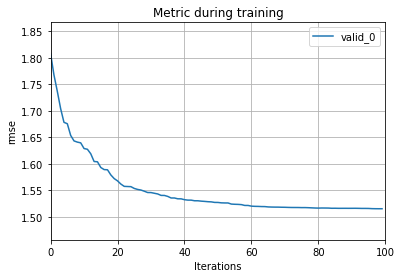

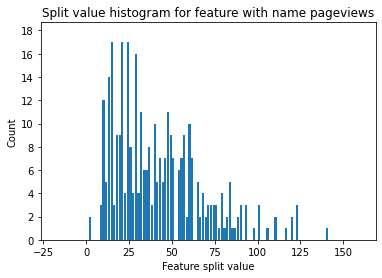

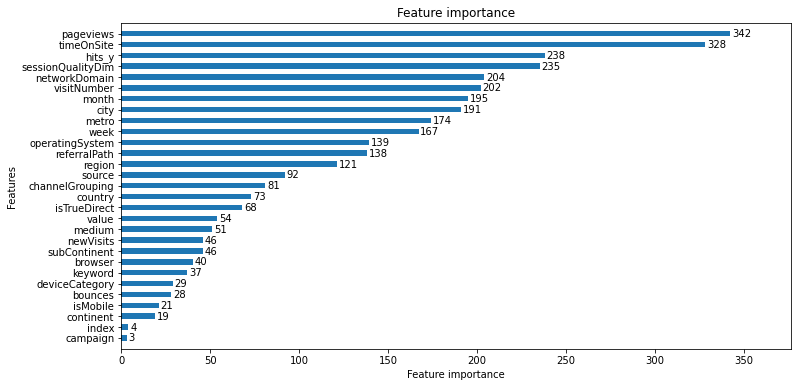

In [28]:
import matplotlib.pyplot as plt
# Split DF
train_x = train_df.drop(['fullVisitorId', 'transactionRevenue', 'totalTransactionRevenue','date','transactions'], axis = 1)
train_y = train_df["totalTransactionRevenue"].values
trn_x, val_x, trn_y, val_y = train_test_split(train_x, train_y, test_size = 0.2, shuffle = False)
test_x = test_df.drop(['fullVisitorId', 'transactionRevenue', 'totalTransactionRevenue','date','transactions'], axis = 1)
test_y = np.log1p(test_df["totalTransactionRevenue"].values)

trn_y = np.log1p(trn_y)
val_y = np.log1p(val_y)

# Transform to lgb dataset
train_data = lgb.Dataset(trn_x, label = trn_y)
test_data = lgb.Dataset(val_x, label = val_y)

# Model parameters
parameters = {
    'objective': 'regression',
    'metric': 'rmse',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 35,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.1,
}

results = {}
model = lgb.train(parameters,
                  train_data,
                  valid_sets=test_data,
                  num_boost_round=100,
                  early_stopping_rounds=100,
                  evals_result= results)
# Evaluate

#execution_time_lgbm = stop - start
#print('Execution time of training Light GBM model:',execution_time_lgbm)

# Plot one metric during training
lgb.plot_metric(results)
plt.show()

# Plot split value histogram for the specified feature of the model
lgb.plot_split_value_histogram(model,'pageviews',grid=False)
plt.show()

figure, ax = plt.subplots(figsize=(12,6))
lgb.plot_importance(model,
                    max_num_features=30,
                    height=0.5,
                    ax=ax,
                    grid=False)
plt.show()